In [1]:
import os
from datetime import datetime, timedelta
from glob import glob

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray
from dask.diagnostics import ProgressBar
from dask.distributed import Client, progress
from tqdm import tqdm

In [2]:
client = Client(n_workers=12)

In [3]:
hres = xarray.open_zarr(
    "/scratch/snx3000/acarpent/EumetsatData/SEVIRI_WGS_2016-2022_RSS.zarr"
).drop_duplicates(dim="time")
hres = hres.rename_dims({"x": "lon", "y": "lat"}).rename_vars({"x": "lon", "y": "lat"})
hres = hres.drop_duplicates(dim="time")
hres

<xarray.Dataset>
Dimensions:      (time: 222098, lat: 658, lon: 736)
Coordinates:
  * time         (time) datetime64[ns] 2016-01-01 ... 2022-12-31T23:45:00
  * lon          (lon) float64 -7.775 -7.725 -7.675 -7.625 ... 28.88 28.93 28.98
  * lat          (lat) float64 28.98 29.03 29.08 29.12 ... 61.73 61.78 61.83
Data variables:
    IR_016       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_039       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_087       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_097       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_108       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_120       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    IR_134       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    VIS006       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    VIS008       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    WV_062       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    WV_073       (time, lat, lon) float32 dask.array<chunksize=(24, 658, 736), meta=np.ndarray>
    spatial_ref  int64 ...

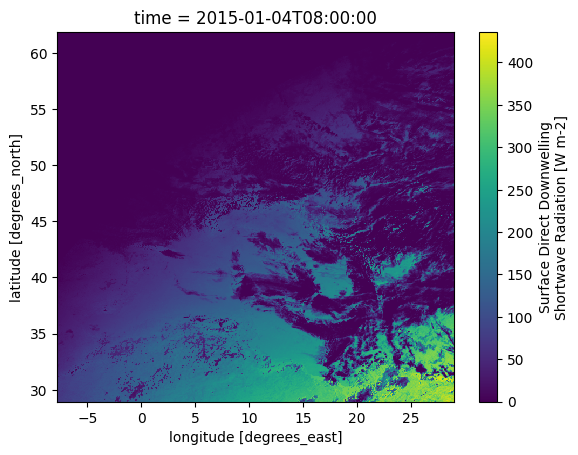

In [12]:
sarah = xarray.open_zarr('/scratch/snx3000/kschuurm/ZARR/SARAH3.zarr')
sarah.SID.isel(time=160).plot.imshow()

In [4]:
lat = hres.lat.copy()
lon = hres.lon.copy()
# del hres



def clean_reindex_sarah3(df):
    df = df.sel(time=df.record_status == 0).drop_vars(
        ["record_status", "lat_bnds", "lon_bnds"]
    )
    # df = clean(df)
    return df.reindex(lat=lat, lon=lon, method="nearest")


def clean_reindex_sarah3_easy(df):
    df = df.sel(time=df.record_status == 0).drop_vars(
        ["record_status", "lat_bnds", "lon_bnds"]
    )
    # df = df.isel(time=timenotnan)
    return df.reindex(lat=lat, lon=lon, method="nearest")

In [8]:
fns = glob("/scratch/snx3000/kschuurm/DATA/SARAH3/SID/SIDin*.nc")

sid = xarray.open_mfdataset(
    fns,
    parallel=True,
    engine="h5netcdf",
    chunks={"time": 48, "lat": -1, "lon": -1},
)
# preprocess=clean_reindex_sarah3)
sid

<xarray.Dataset>
Dimensions:        (time: 140304, lon: 740, bnds: 2, lat: 662)
Coordinates:
  * time           (time) datetime64[ns] 2015-01-01 ... 2023-01-01T23:30:00
  * lon            (lon) float32 -7.975 -7.925 -7.875 ... 28.88 28.92 28.98
  * lat            (lat) float32 28.92 28.98 29.02 29.08 ... 61.88 61.92 61.97
Dimensions without coordinates: bnds
Data variables:
    lon_bnds       (time, lon, bnds) float32 dask.array<chunksize=(48, 740, 2), meta=np.ndarray>
    lat_bnds       (time, lat, bnds) float32 dask.array<chunksize=(48, 662, 2), meta=np.ndarray>
    SID            (time, lat, lon) float32 dask.array<chunksize=(48, 662, 740), meta=np.ndarray>
    record_status  (time) int8 dask.array<chunksize=(48,), meta=np.ndarray>
Attributes: (12/41)
    CDI:                        Climate Data Interface version 1.9.10 (https:...
    institution:                EUMETSAT/CMSAF
    Conventions:                CF-1.7,ACDD-1.3
    id:                         DOI:10.5676/EUM_SAF_CM/SARAH/V003
    product_version:            3.0
    creator_name:               DE/DWD
    ...                         ...
    variable_id:                SID
    title:                      CM SAF Surface Solar Radiation Climate Data R...
    summary:                    This file contains data from the CM SAF Surfa...
    license:                    The CM SAF data are owned by EUMETSAT and are...
    history:                    Tue Feb 27 17:32:56 2024: cdo -v -L -f nc4 -z...
    CDO:                        Climate Data Operators version 1.9.10 (https:...

In [9]:
sid = clean_reindex_sarah3(sid).chunk({"time": 48, "lat": -1, "lon": -1})

In [10]:
a = sid_slice.SID.to_zarr("/scratch/snx3000/kschuurm/ZARR/SARAH3.zarr", mode="a")
del a, sid

In [6]:
fns = glob("/scratch/snx3000/kschuurm/DATA/SARAH3/SIS/SISin*.nc")

sis = xarray.open_mfdataset(
    fns,
    parallel=True,
    engine="h5netcdf",
    chunks={"time": 48, "lat": -1, "lon": -1},
)

In [7]:
sis = clean_reindex_sarah3(sis).chunk({"time": 48, "lat": -1, "lon": -1})

In [8]:
a = sis.SIS.to_zarr("/scratch/snx3000/kschuurm/ZARR/SARAH3.zarr", mode="a")
del a, sis

In [5]:
fns = glob("/scratch/snx3000/kschuurm/DATA/SARAH3/CAL/CALin*.nc")

cal = xarray.open_mfdataset(
    fns,
    parallel=True,
    engine="h5netcdf",
    chunks={"time": 48, "lat": -1, "lon": -1},
)
cal

<xarray.Dataset>
Dimensions:        (time: 140304, lon: 740, bnds: 2, lat: 662)
Coordinates:
  * time           (time) datetime64[ns] 2015-01-01 ... 2023-01-01T23:30:00
  * lon            (lon) float32 -7.975 -7.925 -7.875 ... 28.88 28.92 28.98
  * lat            (lat) float32 28.92 28.98 29.02 29.08 ... 61.88 61.92 61.97
Dimensions without coordinates: bnds
Data variables:
    lon_bnds       (time, lon, bnds) float32 dask.array<chunksize=(48, 740, 2), meta=np.ndarray>
    lat_bnds       (time, lat, bnds) float32 dask.array<chunksize=(48, 662, 2), meta=np.ndarray>
    CAL            (time, lat, lon) float32 dask.array<chunksize=(48, 662, 740), meta=np.ndarray>
    record_status  (time) int8 dask.array<chunksize=(48,), meta=np.ndarray>
Attributes: (12/41)
    CDI:                        Climate Data Interface version 1.9.10 (https:...
    institution:                EUMETSAT/CMSAF
    Conventions:                CF-1.7,ACDD-1.3
    id:                         DOI:10.5676/EUM_SAF_CM/SARAH/V003
    product_version:            3.0
    creator_name:               DE/DWD
    ...                         ...
    variable_id:                CAL
    title:                      CM SAF Surface Solar Radiation Climate Data R...
    summary:                    This file contains data from the CM SAF Surfa...
    license:                    The CM SAF data are owned by EUMETSAT and are...
    history:                    Wed Feb 28 11:24:21 2024: cdo -v -L -f nc4 -z...
    CDO:                        Climate Data Operators version 1.9.10 (https:...

In [6]:
cal = clean_reindex_sarah3(cal).chunk({"time": 48, "lat": -1, "lon": -1})

In [7]:
a = cal.CAL.to_zarr("/scratch/snx3000/kschuurm/ZARR/SARAH3.zarr", mode="a")


In [4]:
SARAH = xarray.open_zarr("/scratch/snx3000/kschuurm/ZARR/SARAH3.zarr")

In [ ]:
import dask


def cal_to_ki(x):
    first_cond = x <= -0.05
    second_cond = (x > -0.05) & (x <= 0.8)
    third_cond = (x > 0.8) & (x <= 1.05)
    fourth_cond = (x > 1.05) & (x < 1.2)
    fifth_cond = x == 1.2

    y = dask.array.zeros(shape=x.shape)

    def func1(x):
        return 1 - x

    def func2(x):
        return 1.1661 - 1.781 * x + 0.73 * x**2

    funcs = [1.05, func1, func2, 0.09, 0]
    conds = [first_cond, second_cond, third_cond, fourth_cond, fifth_cond]

    # y[first_cond] = 1.05
    # y[second_cond] = 1 - x[second_cond]
    # y[third_cond] = 1.1661 - 1.781*x[third_cond] + 0.73*x[third_cond]**2
    # y[fourth_cond] = 0.09
    # y[fifth_cond] = 0
    return dask.array.piecewise(x, conds, funcs)


def cal_to_ki2(x):
    y = np.nan
    if x <= -0.05:
        y = 1.05
    elif x > -0.05 & x <= 0.8:
        y = 1 - x
    elif x > 0.8 & x <= 1.05:
        y = 1.1661 - 1.781 * x + 0.73 * x**2
    elif x > 1.05 & x < 1.2:
        y = 0.09
    elif x == 1.2:
        y = 0
    return y

In [6]:
ki = xarray.apply_ufunc(cal_to_ki, SARAH.CAL, dask="allowed")

In [7]:
ki = ki.rename("KI")

In [8]:
ki = ki.assign_attrs(SARAH.CAL.attrs)
ki.attrs["long_name"] = "Clear Sky Index"

In [9]:
ki.to_zarr("/scratch/snx3000/kschuurm/ZARR/SARAH3.zarr", mode="a")

In [3]:
SARAH = xarray.open_zarr("/scratch/snx3000/kschuurm/ZARR/SARAH3.zarr")
SARAH

<xarray.Dataset>
Dimensions:  (time: 139915, lat: 658, lon: 736)
Coordinates:
  * lat      (lat) float32 28.98 29.02 29.08 29.12 ... 61.67 61.72 61.78 61.83
  * lon      (lon) float32 -7.775 -7.725 -7.675 -7.625 ... 28.88 28.92 28.98
  * time     (time) datetime64[ns] 2015-01-01 ... 2023-01-01T23:30:00
Data variables:
    CAL      (time, lat, lon) float32 dask.array<chunksize=(48, 658, 736), meta=np.ndarray>
    KI       (time, lat, lon) float32 dask.array<chunksize=(48, 658, 736), meta=np.ndarray>
    SID      (time, lat, lon) float32 dask.array<chunksize=(48, 658, 736), meta=np.ndarray>
    SIS      (time, lat, lon) float32 dask.array<chunksize=(48, 658, 736), meta=np.ndarray>

In [9]:
import concurrent
def check(x):
    return np.isnan(x).any()


def check_all(x):
    return np.isnan(x).all()


def check_sum(x):
    return np.isnan(x).sum()


def compute_bnds(x):
    i = 0
    j = 0
    i_max = 740
    j_max = 662
    step = 20
    angle_step = j_max // 2
    if not check_all(x):
        c = check(x)
        if c:
            c_ul = check_sum(
                x.isel(
                    lon=slice(i, i + angle_step), lat=slice(j_max - angle_step, j_max)
                )
            )
            c_ur = check_sum(
                x.isel(
                    lon=slice(i_max - angle_step, i_max),
                    lat=slice(j_max - angle_step, j_max),
                )
            )
            c_ll = check_sum(
                x.isel(lon=slice(i, i + angle_step), lat=slice(j, j + angle_step))
            )
            c_lr = check_sum(
                x.isel(
                    lon=slice(i_max - angle_step, i_max), lat=slice(j, j + angle_step)
                )
            )

            if c_ul > c_ur and c_ul > c_ll and c_ul > c_lr:
                c = check(x.isel(lon=slice(i, i_max), lat=slice(j, j_max)))
                while c:
                    j_max -= step
                    i += step
                    c = check(lon.isel(lon=slice(i, i_max), lat=slice(j, j_max)))

            elif c_ur > c_ul and c_ur > c_ll and c_ur > c_lr:
                c = check(lon.isel(lon=slice(i, i_max), lat=slice(j, j_max)))
                while c:
                    i_max -= step
                    j_max -= step
                    c = check(lon.isel(x=slice(i, i_max), lat=slice(j, j_max)))

            elif c_ll > c_ul and c_ll > c_ur and c_ll > c_lr:
                c = check(x.isel(lon=slice(i, i_max), lat=slice(j, j_max)))
                while c:
                    i += step
                    j += step
                    c = check(x.isel(lon=slice(i, i_max), lat=slice(j, j_max)))

            elif c_lr > c_ul and c_lr > c_ur and c_lr > c_ll:
                c = check(x.isel(lon=slice(i, i_max), lat=slice(j, j_max)))
                while c:
                    i_max -= step
                    j += step
                    c = check(x.isel(lon=slice(i, i_max), lat=slice(j, j_max)))
            else:
                return None
    else:
        return None

    if i_max > i + 128 and j_max > j + 128:
        return i, j, i_max, j_max
    else:
        return None


def clean(x):
    # compute indeces of images with less than 50% nans
    img_x_dim = x.lon.shape[0]
    img_y_dim = x.lat.shape[0]
    time = x.time
    idx = np.where(np.isnan(x).sum(axis=(1, 2)) / (img_x_dim * img_y_dim) < 0.5)[0]

    # initialize indices lists
    final_idx = []
    min_x_lst = []
    min_y_lst = []
    max_x_lst = []
    max_y_lst = []
    
    def compute_minmax_bnds(j):
        bnd = compute_bnds(x[j])
        if bnd is not None:
            if bnd[2] > bnd[0] + 128 and bnd[3] > bnd[1] + 128:
                return j, bnd[0], bnd[1], bnd[2], bnd[3]
        else:
            return None
    # compute image boundaries for every admitted index
    with concurrent.futures.ThreadPoolExecutor() as pool:
        # out = pool.map(compute_minmax_bnds, idx)
        out = list(tqdm(pool.map(compute_minmax_bnds, idx), total=len(idx)))
        
    out = [x for x in out if x is not None]
    (final_idx, min_x_lst, min_y_lst, max_x_lst, max_y_lst) = zip(*out)
    # for j in tqdm(idx):
    #     bnd = compute_bnds(x[j])
    #     if bnd is not None:
    #         if bnd[2] > bnd[0] + 128 and bnd[3] > bnd[1] + 128:
    #             final_idx.append(j)
    #             min_x_lst.append(bnd[0])
    #             min_y_lst.append(bnd[1])
    #             max_x_lst.append(bnd[2])
    #             max_y_lst.append(bnd[3])
    
    print('adfa', len(final_idx), final_idx)
    ds = xarray.Dataset({
        'final_idx':('time', final_idx),
        'min_x_lst':('time', min_x_lst),
        'min_y_lst':('time', min_y_lst),
        'max_x_lst':('time', max_x_lst),
        'max_y_lst':('time', max_y_lst),},
        coords={'time':time.isel(time=final_idx)},)
        
        
    
    return ds

In [10]:
ds = clean(SARAH.SIS.isel(time=slice(0,100)))

100%|██████████| 100/100 [00:04<00:00, 24.77it/s]


adfa 100 (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99)


TypeError: Variable None: Could not convert tuple of form (dims, data[, attrs, encoding]): (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99) to Variable.

In [ ]:
ds.to_zarr('temp_sarah_notnanbounds.zarr',mode='w')

In [ ]:
np.save('final_idx', final_idx)
np.save('min_x_lst', min_x_lst)
np.save('min_y_lst', min_y_lst)
np.save('max_x_lst', max_x_lst)
np.save('max_y_lst', max_y_lst)


In [34]:
SARAH.CAL.isnull().sum().values

array(35562710757)